# 1. Užduotis

Duomenys iš pirmos užduoties 2) punkto, t.y. stebėtas a.d., turintis Veibulo skirstinį su
parametrais $\eta$ ir $\nu$, t. y. a. d. $T$ pasiskirstymo funkcija yra

$$
F(t; \eta, \nu) = 1 - \exp{\{ - {(t / \eta)}^\nu \}},
$$

gauta didumo $n = 100$ paprastoji atsitiktinė imtis.

In [310]:
library(latex2exp)

In [216]:
set.seed(314)

n <- 100
eta <- 2 # laisvai pasirinkti 
nu <- 2

weibull_inverse_cdf <- function(theta) {
    function(probs) {
        theta[1] * (-1 * log(1 - probs)) ^ (1 / theta[2])
    }
}

observ <- weibull_inverse_cdf(c(eta, nu))(runif(n))

**Pastaba:** Taškiniai įverčiai buvo rasti pirmoje užduotyje.

In [217]:
# Analogiškai pirmosios dalies antrai užduočiai:
gamma <- 0.5772156 
sigma_hat_moment <- function(x) { sqrt(6 * var(x)) / pi }
mu_hat_moment <- function(x) { mean(x) + gamma * sigma_hat_moment(x) }

In [218]:
(start_eta <- exp(mu_hat_moment(log(observ))))
(start_nu <- 1 / sigma_hat_moment(log(observ)))

[1] 1.820739

[1] 1.919287

In [219]:
weibull_loglik <- function(observ) {
    log_sum <- sum(log(observ))
    n <- length(observ)

    function(theta) {
        eta <- theta[1]
        nu <- theta[2]
        
        n * (log(eta) - log(nu))
        - (1 / nu^eta) * sum(observ^eta)
        + (eta - 1) * (log_sum - n * log(nu))
    }
}

optim_optimiser <- function(f, start) {
    mle <- stats::optim(
        start, f,
        method = "L-BFGS-B",
        hessian = TRUE
    )
    r <- list(
        estimates = mle$par,
        hessian = mle$hessian
    )
    return(r)
}

mle_estimator <- function(loglikelihood, optimiser) {
    function(data, start) {
        optimiser(loglikelihood(data), start)
    }
}

weibull_mle_estimator <- mle_estimator(weibull_loglik, optim_optimiser)

In [220]:
(theta_hat_mle <- weibull_mle_estimator(observ, c(start_eta, start_nu)))

-8.881784e-10,-52.10270
-5.210270e+01,22.28055


a) Raskite stebėtą Fišerio informacinę matricą.

In [221]:
(fishers_info <- -1 * theta_hat_mle$hessian)

8.881784e-10,52.10270
5.210270e+01,-22.28055


b) Raskite parametrų pasikliovimo intervalus. Rezultatus (tikros parametrų reikšmės,
taškiniai įverčiai ir pasikliovimo intervalai) pateikite duomenų lentelėje (dataframe).

Pasinaudosime Didžiausio Tikėtinumo įvertinių asimptotiniu normalumu:

In [222]:
mle_asymptotic_ci <- function(mle, sample_size) {
    mle_estimates <- mle$estimates
    fishers_info <- -1 * mle$hessian
    
    # Precalculate:
    fishers_inverse <- solve(fishers_info)
    sqrt_size <- sqrt(sample_size)

    function(confidence) {
        i <- 1
        alpha_half <- (1 - confidence) / 2 

        lapply(mle_estimates, function(e) {
            variance <- fishers_inverse[i, i]
            shift <- sqrt(variance) * qnorm(alpha_half, lower.tail = FALSE) / sqrt_size
            i <- i + 1

            ci <- list(
                lo = e - shift,
                hi = e + shift
            )
                
            return(ci)
        })
    }
}

In [223]:
weibull_ci <- mle_asymptotic_ci(theta_hat_mle, n)
ci95 <- weibull_ci(0.87)

In [224]:
eta_hat_mle <- theta_hat_mle$estimates[1]
nu_hat_mle <- theta_hat_mle$estimates[2]

data.frame(
    name = c("eta", "nu"),
    actual = c(eta, nu),
    lo_95 = c(ci95[[1]]$lo, ci95[[2]]$lo),
    ml_estimate = c(eta_hat_mle, nu_hat_mle),
    hi_95 = c(ci95[[1]]$hi, ci95[[2]]$hi) 
)

name,actual,lo_95,ml_estimate,hi_95
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
eta,2,1.807022,1.820739,1.834456
nu,2,1.905570,1.919287,1.933003


c) Raskite tikimybės, kad stebėtas a.d. įgis reikšmę didesnę už $t$, pasikliovimo intervalą.
Rezultatus ($t$, tikra tikimybės reikšmė, tikimybės įvertis, pasikliovimo lygmuo, pasikliovimo
intervalas) pateikite duomenų lentelėje (dataframe).

Tikimybė kad $X$ reikšmė didesnė už $t$ arba $P(X > t) = 1 - F(x) = S(x)$, kitaip tariant - išgyvenamumo funkcija. Taigi, turime rasti $S(t)$ įverčio pasikliovimo intervalą.

In [235]:
survival <- function(theta) {
    eta <- theta[1]
    nu <- theta[2]

    function(t) {
        exp(-1 * (t / eta)^nu)
    }
}

diff_survival_d_eta <- function(theta) {
    eta <- theta[1]
    nu <- theta[2]
    
    function(t) {
         nu * t * (t / eta)^(nu - 1) * exp(-(t / eta)^nu) / eta^2
    }  
}

diff_survival_d_nu <- function(theta) {
    eta <- theta[1]
    nu <- theta[2]
    
    function(t) {
        -(t / eta)^nu * exp(-(t / eta)^nu) * log(t / eta)
    }
}

Pasinaudosime pastaba esančia sąlygų priede:

In [274]:
## Evaluates the confidence interval of a survival function estimate \hat{S}(t) at point t
ci_mle_survival <- function(theta_hat, fishers_info, survival_f, survival_partial_fs, confidence = 0.95, sample_size) {

    alpha <- 1 - confidence
    critical_value <- qnorm(alpha / 2, mean = 0, sd = 1, lower.tail = FALSE)
    
    inverted_info_single <- solve(fishers_info / sample_size)
    survival_hat <- survival_f(theta_hat)    
    sqrt_sample_size <- sqrt(sample_size)
    
    function(t) {
        partials <- sapply(survival_partial_fs, function(s) {
            s(theta_hat)(t)
        })

        variance <- t(partials) %*% inverted_info_single %*% partials

        expr0 <- sqrt(variance) / (survival_hat(t) * (1 - survival_hat(t)))
        expr1 <- (1 - survival_hat(t)) / survival_hat(t)
        expr2 <- expr0 * critical_value / sqrt_sample_size
    
        lo <- 1 / (1 + expr1 * exp(expr2))
        hi <- 1 / (1 + expr1 * exp(-expr2))
        
        c(lo = lo, point = survival_hat(t), hi = hi)
    }
}

In [275]:
ci <- ci_mle_survival(
    theta_hat = c(eta_hat_mle, nu_hat_mle),
    fishers_info = fishers_info,
    survival_f = survival,
    survival_partial_fs = c(diff_survival_d_eta, diff_survival_d_nu),
    confidence = 0.89,
    sample_size = n
)

In [305]:
ts <- seq(0.1, 2, length.out = 100)

df <- data.frame(t(sapply(ts, function(t) {
    estim <- unname(ci(t))
    actual <- survival(c(eta, nu))(t)
    
    c(
        actual = actual,
        lo = estim[1],
        pointwise = estim[2],
        hi = estim[3]
    )
})))

df$t <- ts

tail(df)

,actual,lo,pointwise,hi,t
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
95,0.4039992,0.2882240,0.3363329,0.3880935,1.904040
96,0.3966482,0.2826505,0.3292850,0.3795429,1.923232
97,0.3893592,0.2771929,0.3223220,0.3710269,1.942424
98,0.3821338,0.2718530,0.3154446,0.3625458,1.961616
99,0.3749734,0.2666330,0.3086538,0.3540995,1.980808
100,0.3678794,0.2615353,0.3019505,0.3456874,2.000000


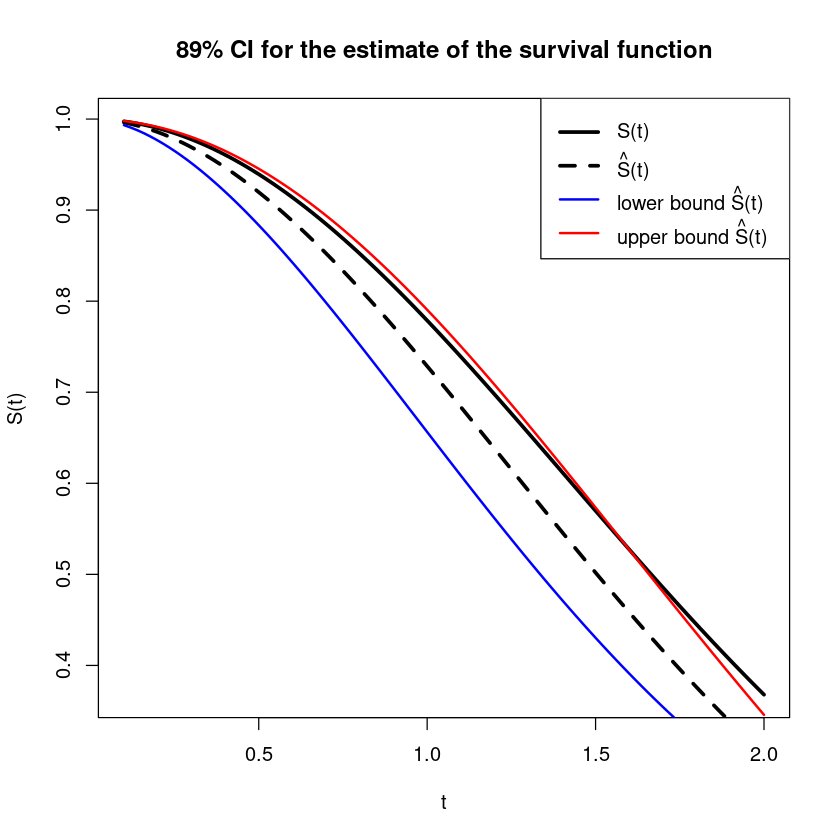

In [323]:
plot(df$t, df$actual, col = "black", type = "l", lwd = 3, xlab = "", ylab = "")
lines(df$t, df$pointwise, col = "black", lwd = 3, lty = 2)
lines(df$t, df$lo, col = "blue", lwd = 2, lty = 1)
lines(df$t, df$hi, col = "red", lwd = 2, lty = 1)
title(
    main = "89% CI for the estimate of the survival function",
    xlab = "t",
    ylab = "S(t)"
)
legend(
    "topright",
    legend = c(TeX("$S(t)$"), TeX("$\\hat{S}(t)$"), TeX("lower bound $\\hat{S}(t)$"), TeX("upper bound $\\hat{S}(t)$")),
    col = c("black", "black", "blue", "red"),
    lty = c(1, 2, 1, 1),
    lwd = c(3, 3, 2, 2)
)

d) Raskite intervalinį medianos įvertį. Rezultatus (tikra medianos reikšmė, taškinis
įvertis, pasikliovimo lygmuo ir pasikliovimo intervalas) pateikite duomenų lentelėje (dataframe).

In [431]:
ci_mle_quantile <- function(theta_hat, fishers_info, quantile_f, quantile_partial_fs, confidence = 0.95, sample_size) {

    alpha <- 1 - confidence
    critical_value <- qnorm(alpha / 2, mean = 0, sd = 1, lower.tail = FALSE)
    
    inverted_info_single <- solve(fishers_info / sample_size) 

    quantile_hat <- quantile_f(theta_hat)
    sqrt_sample_size <- sqrt(sample_size)

    function(q) {
        partials <- sapply(quantile_partial_fs, function(f) {
            f(theta_hat)(q)
        })

        variance <- abs(t(partials) %*% inverted_info_single %*% partials)

        pointwise <- quantile_hat(q)
        shift <- sqrt(variance) * critical_value / sqrt_sample_size

        lo <- pointwise - shift
        hi <- pointwise + shift
        
        c(lo = lo, point = pointwise, hi = hi)
    }
}

In [432]:
quantile <- function(theta) {
    eta <- theta[1]
    nu <- theta[2]
    
    function(q) {
        eta * (-1 * log(1 - q))^(1 / nu)
    }
}

diff_quantile_d_eta <- function(theta) {
    eta <- theta[1]
    nu <- theta[2]
    
    function(q) {
        (-log(1 - q))^(1 / nu)
    }
}

diff_quantile_d_nu <- function(theta) {
    eta <- theta[1]
    nu <- theta[2]
    
    function(q) {
        -eta * (-log(1 - q))^(1 / nu) * log(-log(1 - q)) / nu^2
    }
}

In [433]:
ci_quantile <- ci_mle_quantile(
    theta_hat = c(eta_hat_mle, nu_hat_mle),
    fishers_info = fishers_info,
    quantile_f = quantile,
    quantile_partial_fs = c(diff_quantile_d_eta, diff_quantile_d_nu),
    confidence = 0.89,
    sample_size = n
)

In [434]:
ci_quantile(0.5)

lo    point       hi 
1.341649 1.504228 1.666806

e) Raskite $p$-ojo kvantilio pasikliovimo intervalą. Rezultatus (kvantilio lygmuo $p$, tikra
kvantilio reikšmė, taškinis įvertis, pasikliovimo lygmuo ir pasikliovimo intervalas) pateikite
duomenų lentelėje (dataframe)

In [438]:
qs <- seq(0.1, 0.99, length.out = 100)

df_quantile <- data.frame(t(sapply(qs, function(q) {
    
    estim <- unname(ci_quantile(q))
    actual <- quantile(c(eta, nu))(q)
    
    c(
        q = q,
        actual = actual,
        lo = estim[1],
        pointwise = estim[2],
        hi = estim[3]
    )
})))



tail(df_quantile)

,q,actual,lo,pointwise,hi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
95,0.9450505,3.406665,2.866579,3.171569,3.476560
96,0.9540404,3.509982,2.942704,3.271865,3.601025
97,0.9630303,3.631890,3.032861,3.390368,3.747874
98,0.9720202,3.782207,3.144396,3.536715,3.929034
99,0.9810101,3.981883,3.293000,3.731495,4.169991
100,0.9900000,4.291932,3.524369,4.034750,4.545131


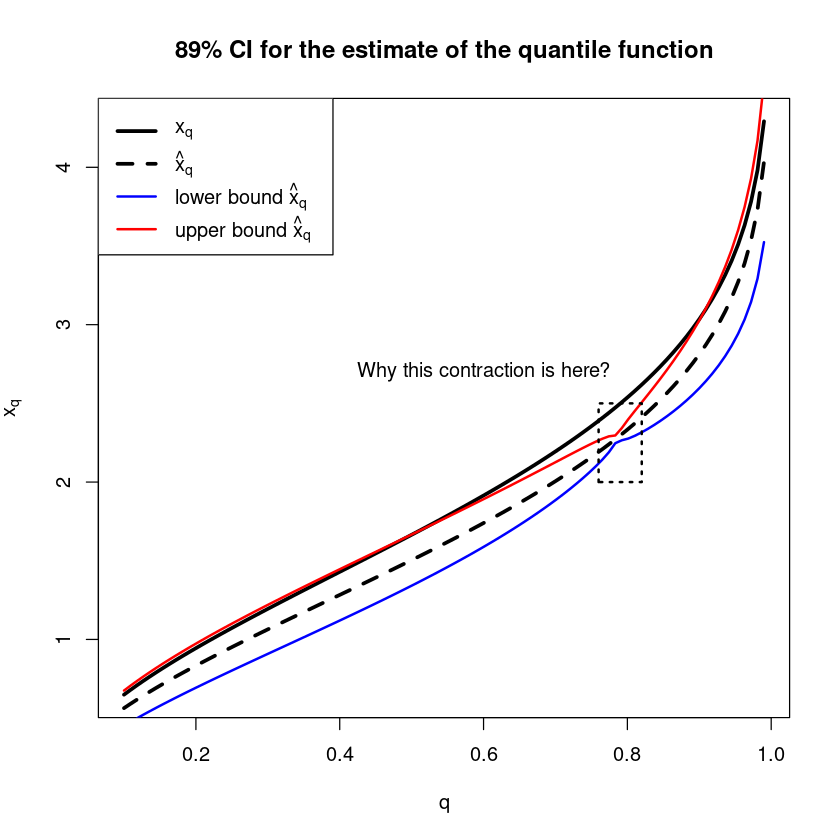

In [463]:
plot(df_quantile$q, df_quantile$actual, col = "black", type = "l", lwd = 3, xlab = "", ylab = "")
lines(df_quantile$q, df_quantile$pointwise, col = "black", lwd = 3, lty = 2)
lines(df_quantile$q, df_quantile$lo, col = "blue", lwd = 2, lty = 1)
lines(df_quantile$q, df_quantile$hi, col = "red", lwd = 2, lty = 1)
title(
    main = "89% CI for the estimate of the quantile function",
    xlab = "q",
    ylab = TeX("$x_q$")
)
legend(
    "topleft",
    legend = c(TeX("$x_q$"), TeX("$\\hat{x}_q$"), TeX("lower bound $\\hat{x}_q$"), TeX("upper bound $\\hat{x}_q$")),
    col = c("black", "black", "blue", "red"),
    lty = c(1, 2, 1, 1),
    lwd = c(3, 3, 2, 2)
)

p1 <- c(0.78, 2, 0.78, 2)


polygon(c(0.76, 0.76, 0.82, 0.82), c(2, 2.5, 2.5, 2), border = "black", lwd = 2, lty = 3)
text(x = 0.6, y = 2.7, label = "Why this contraction is here?")